# Predicting eGFR at 1 year
> This notebook contains regression models used to predict the eGFR at 1 year variable.



We evaluated one statistical model (linear regression) and three machine learning models (XGBoost regression, Random Forest regression and Support Vector regression).

The first half of the notebook follows the following layout:
1. Import Libraries 
2. Sorting and Splitting Data
3. Linear Regression Model
4. XGBoost Regression Model
5. Random Forest Regression Model
6. Support Vector Regression Model

The next part compares the models using the T-Test.

We then predict the eGFR at 1 year variable without the PRS scores. In this section we implemented the same models as before. 


In [ ]:
#| default_exp prediction

In [ ]:
#| hide
from nbdev.showdoc import *

## 1. Import Libraries

In [ ]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate

df_pheno = pd.read_pickle('../../../D/2023-ca4021-bradyd-35-mcdaida-3/data/proc/pheno_cluster.pkl')

In [ ]:
df_pheno.columns

Index(['DonAge', 'RecAge', 'DonSex', 'RecSex', 'SexMismatch', 'Year',
       'IntracranialHaemorrhage', 'RecPC1', 'RecHypertensionPRS',
       'DonHypertensionPRS', 'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS',
       'ColdIschemiaTime', 'GraftNo', 'eGFR1Year', 'eGFR5Year',
       'GraftSurvivalDays', 'MClustClusters', 'KamilaClusters'],
      dtype='object')

In [ ]:
#| export
def evaluate_model(predict, y_test):
    ### Calculate the mean squared error
    ## Average squared difference between the observed and the predicted values.
    ### Calculate the absolute errors
    ### Difference between the observed and the predicted values.
    ## R squared score
    ## Explains to what extent the variance of one variable explains the variance of the second variable.
    rmse = np.sqrt(mean_squared_error(y_test, predict))
    errors = abs(predict - y_test)
    mae = np.mean(errors)
    r_square = r2_score(y_test, predict)
    
    table = [['RMSE', 'MAE', 'R Squared'], [rmse, mae, r_square]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    
    ## Return list of errors in an array
    difference = y_test - predict
    error_array = np.array(difference)
    return error_array


## 2. Sorting and Splitting Data

In [ ]:
df_pheno.dtypes

DonAge                      float64
RecAge                      float64
DonSex                     category
RecSex                     category
SexMismatch                    bool
Year                        float64
IntracranialHaemorrhage        bool
RecPC1                      float64
RecHypertensionPRS          float64
DonHypertensionPRS          float64
DoneGFRPRS                  float64
DonStrokePRS                float64
RecHAKVPRS                  float64
ColdIschemiaTime            float64
GraftNo                     float64
eGFR1Year                   float64
eGFR5Year                   float64
GraftSurvivalDays           float64
MClustClusters             category
KamilaClusters             category
dtype: object

In [ ]:
## Changing column RecSex/DonSex from category to type int
df_pheno['DonSex'].replace(['Male', 'Female'], [0,1], inplace=True)
df_pheno['RecSex'].replace(['Male', 'Female'], [0,1], inplace=True)
df_pheno['DonSex'] = df_pheno['DonSex'].astype(int)
df_pheno['RecSex'] = df_pheno['RecSex'].astype(int)

## remove null values in eGFR 1 year
df_pheno = df_pheno.dropna(subset=['eGFR1Year'])

In [ ]:
df_pheno.dtypes

DonAge                      float64
RecAge                      float64
DonSex                        int64
RecSex                        int64
SexMismatch                    bool
Year                        float64
IntracranialHaemorrhage        bool
RecPC1                      float64
RecHypertensionPRS          float64
DonHypertensionPRS          float64
DoneGFRPRS                  float64
DonStrokePRS                float64
RecHAKVPRS                  float64
ColdIschemiaTime            float64
GraftNo                     float64
eGFR1Year                   float64
eGFR5Year                   float64
GraftSurvivalDays           float64
MClustClusters             category
KamilaClusters             category
dtype: object

In [ ]:
## Need to drop 'eGFR5Year' 'GraftSurvivalDays' as not available pre transplant
## 'MClustClusters' 'KamilaClusters' as this is for the cluster-prediction
df_pheno = df_pheno.drop(['eGFR5Year', 'GraftSurvivalDays', 'MClustClusters', 'KamilaClusters'], axis=1)

In [ ]:
df_pheno.head()

,DonAge,RecAge,DonSex,RecSex,SexMismatch,Year,IntracranialHaemorrhage,RecPC1,RecHypertensionPRS,DonHypertensionPRS,DoneGFRPRS,DonStrokePRS,RecHAKVPRS,ColdIschemiaTime,GraftNo,eGFR1Year
0,25.0,54.0,1,1,True,2000.0,False,-0.001810,0.574557,0.041781,-0.068460,-2.471242,-0.329893,1080.0,1.0,37.016586
1,37.0,35.0,0,0,True,2001.0,False,-0.009447,-0.374240,0.829304,0.975353,0.069456,0.439058,1110.0,1.0,75.068169
2,22.0,53.0,1,1,True,2002.0,False,-0.006079,0.050664,0.204120,-0.613161,-0.701665,0.004753,1102.0,1.0,59.602940
3,48.0,33.0,1,0,False,2002.0,True,-0.005711,-0.178995,0.322234,-0.446593,-0.399453,-1.000807,740.0,1.0,50.073505
4,39.0,61.0,0,0,True,1999.0,False,-0.010986,-0.090834,-0.195021,1.232662,1.297929,-1.184922,1072.0,1.0,43.704456


In [ ]:
x = df_pheno.drop(['eGFR1Year'], axis = 1)
y = df_pheno['eGFR1Year']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

## 3. Linear Regression Model

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
predicts = lin_reg.predict(x_test)

In [ ]:
error = evaluate_model(predicts, y_test)

╒════════╤════════╤═════════════╕
│   RMSE │    MAE │   R Squared │
╞════════╪════════╪═════════════╡
│ 15.405 │ 12.438 │    0.295026 │
╘════════╧════════╧═════════════╛


### Regularization and hyperparameter tuning

In [ ]:
# define hyperparameters to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
          'normalize': [True, False],
          'fit_intercept': [True, False]}

# create linear regression model
lasso_model = Lasso()

# use grid search to find best hyperparameters
grid_search = GridSearchCV(lasso_model, param_grid=params, cv=5)
grid_search.fit(x_train, y_train)
grid_search_pred = grid_search.predict(x_test)

lin_error = evaluate_model(grid_search_pred, y_test)

## Printing the parameters that generated the best results
print("Best parameters:", grid_search.best_params_)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.3837 │ 12.4184 │     0.29697 │
╘═════════╧═════════╧═════════════╛
Best parameters: {'alpha': 0.1, 'fit_intercept': True, 'normalize': False}


### Plot the observed vs the predicted

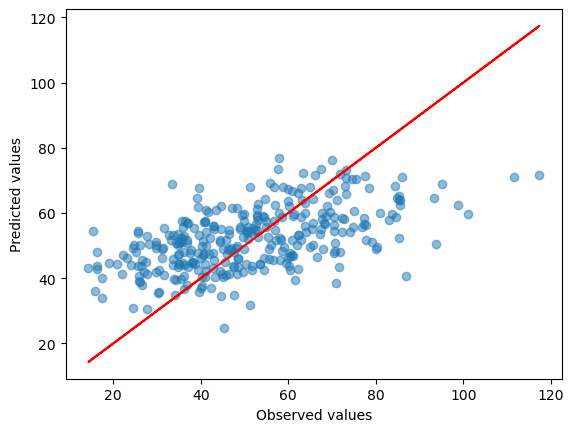

In [ ]:
## Create a scatter plot of the predicted values vs the observed values
plt.scatter(y_test, grid_search_pred, alpha=0.5)

## Add the line of best fit
plt.plot(y_test, y_test, color='red')

## set the x and y labels
plt.xlabel('Observed values')
plt.ylabel('Predicted values')

plt.show()

### Plotting the residuals

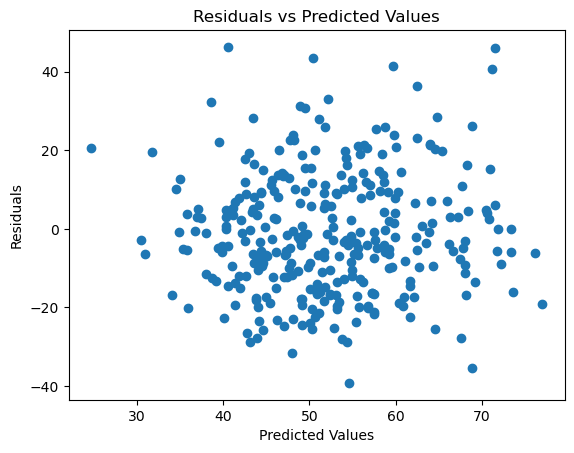

In [ ]:
y_pred = grid_search_pred
y_actual = y_test

## Calculate the residuals by subtracting the predicted values from the actual values
residuals = y_actual - y_pred

## Calculate the mean and standard deviation
residuals_mean = residuals.mean()
residuals_std = residuals.std()

## Visualise the residuals using a scatter plot
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

### Looking at the incorrect predictions

In [ ]:
y_pred = grid_search_pred
y_actual = y_test
difference = y_actual - y_pred

df_linear = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Difference': difference})

## Find the incorrect predictions
incorrect_predictions = df_linear.loc[df_linear['Actual'] != df_linear['Predicted']]

incorrect_predictions.describe()

,Actual,Predicted,Difference
count,323.000000,323.000000,323.000000
mean,51.061853,52.191223,-1.129370
std,18.375866,9.471560,15.366017
min,14.314533,24.727871,-39.209719
25%,36.893264,44.919187,-12.245509
50%,49.347635,51.662151,-2.830649
75%,63.032060,58.426314,9.159340
max,117.388622,76.948630,46.266917


## 4. XGBoost Regression Model

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(x_train,y_train)

predicts = xg_reg.predict(x_test)

error = evaluate_model(predicts, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 24.2013 │ 19.2131 │   -0.739921 │
╘═════════╧═════════╧═════════════╛


### Feature Importance

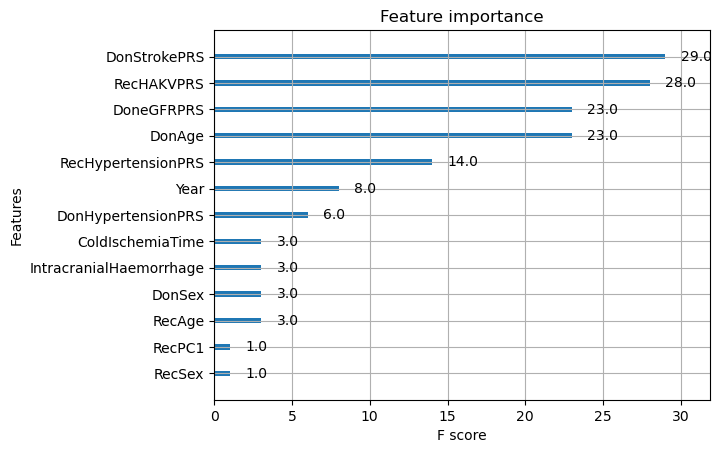

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### Regularization and hyperparameter tuning

In [ ]:
# Combining regularization and hyperparameter tuning

param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.1, 0.5],
              'max_depth': [3, 5, 7],
              'reg_alpha': [0.1],
              'reg_lambda': [0.1]}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xg_reg, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
grid_search_pred = grid_search.predict(x_test)

xg_error = evaluate_model(grid_search_pred, y_test)

## Printing the parameters that generated the best results
print("Best parameters:", grid_search.best_params_)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.1818 │ 12.2298 │    0.315303 │
╘═════════╧═════════╧═════════════╛
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


### Plot the observed vs the predicted values

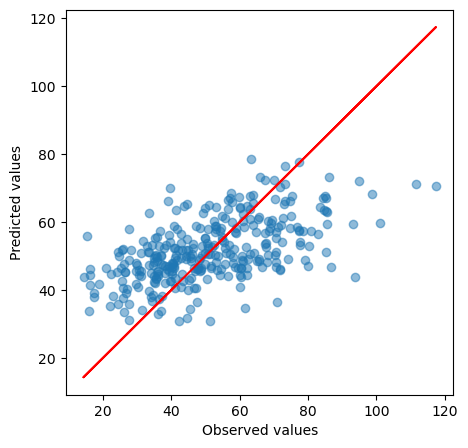

In [ ]:
## Create a scatter plot of the predicted values vs the observed values
plt.scatter(y_test, grid_search_pred, alpha=0.5)

## Add the line of best fit
plt.plot(y_test, y_test, color='red')

## set the x and y labels
plt.xlabel('Observed values')
plt.ylabel('Predicted values')

plt.show()

### Plotting the Residuals

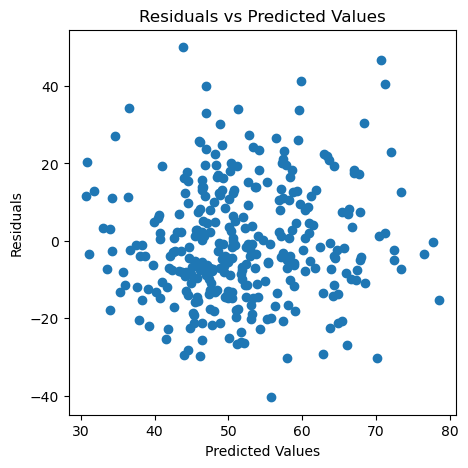

In [ ]:
y_pred = grid_search_pred
y_actual = y_test

## Calculate the residuals by subtracting the predicted values from the actual values
residuals = y_actual - y_pred

## Calculate the mean and standard deviation
residuals_mean = residuals.mean()
residuals_std = residuals.std()

## Visualise the residuals using a scatter plot
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

### Looking at the incorrect predictions

In [ ]:
y_pred = grid_search_pred
difference = y_actual - y_pred

df_xgBoost = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Difference': difference})

## Find the incorrect predictions
incorrect_predictions = df_xgBoost.loc[df_xgBoost['Actual'] != df_xgBoost['Predicted']]

incorrect_predictions.describe()

,Actual,Predicted,Difference
count,323.000000,323.000000,323.000000
mean,51.061853,51.722294,-0.660439
std,18.375866,9.316399,15.177545
min,14.314533,30.738081,-40.437055
25%,36.893264,45.749424,-11.056669
50%,49.347635,50.414505,-2.671254
75%,63.032060,57.926859,9.718018
max,117.388622,78.461533,50.047040


## 5. Random Forest Regression Model

In [ ]:
rf_reg = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_reg.fit(x_train,y_train)
predictions = rf_reg.predict(x_test)

In [ ]:
error = evaluate_model(predictions, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.4336 │ 12.6331 │    0.292401 │
╘═════════╧═════════╧═════════════╛


### Feature Importance

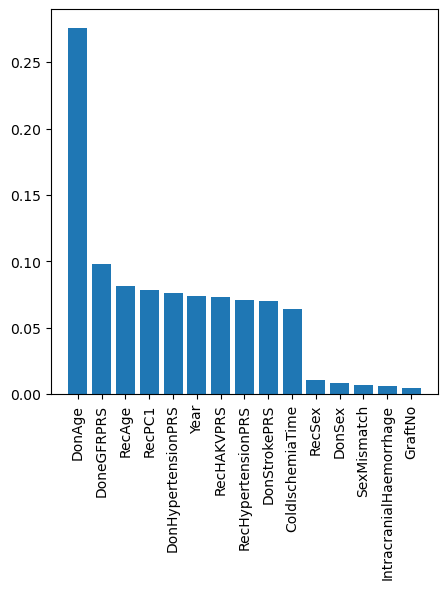

In [ ]:
# plot feature importance
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.show()

### Hyperparameter Tuning and Regularization

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'max_features': ['auto','sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.5]
}

rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(rf_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
grid_search_pred = grid_search.predict(x_test)

rf_error = evaluate_model(grid_search_pred, y_test)
## Printing the parameters that generated the best results
print("Best parameters:", grid_search.best_params_)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.3867 │ 12.5338 │    0.296694 │
╘═════════╧═════════╧═════════════╛
Best parameters: {'ccp_alpha': 0.5, 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


## 6. Support Vector Regression

In [ ]:
svr_reg = SVR(kernel = 'linear', C=1, epsilon=0.1)

svr_reg.fit(x_train,y_train)

predictions = svr_reg.predict(x_test)

In [ ]:
error = evaluate_model(predictions, y_test)

╒════════╤═════════╤═════════════╕
│   RMSE │     MAE │   R Squared │
╞════════╪═════════╪═════════════╡
│  15.41 │ 12.3252 │    0.294569 │
╘════════╧═════════╧═════════════╛


In [ ]:
svr_reg = SVR(kernel = 'rbf', C=1, epsilon=0.1)
svr_reg.fit(x_train,y_train)
predictions = svr_reg.predict(x_test)
error = evaluate_model(predictions, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 18.3631 │ 14.8906 │  -0.0017101 │
╘═════════╧═════════╧═════════════╛


In [ ]:
svr_reg = SVR(kernel = 'sigmoid', C=1, epsilon=0.1)
svr_reg.fit(x_train,y_train)
predictions = svr_reg.predict(x_test)
error = evaluate_model(predictions, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 18.3589 │ 14.8879 │ -0.00125486 │
╘═════════╧═════════╧═════════════╛


In [ ]:
svr_reg = SVR(kernel = 'poly', C=1, epsilon=0.1)
svr_reg.fit(x_train,y_train)
predictions = svr_reg.predict(x_test)
error = evaluate_model(predictions, y_test)

╒═════════╤═════════╤══════════════╕
│    RMSE │     MAE │    R Squared │
╞═════════╪═════════╪══════════════╡
│ 18.3487 │ 14.8734 │ -0.000145106 │
╘═════════╧═════════╧══════════════╛


### Regularization and Hyperparameter Tuning

In [ ]:
# Define the parameter grid for the SVR model
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'gamma': ['scale']
}

svr = SVR()

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

grid_search_pred = grid_search.predict(x_test)

svr_error = evaluate_model(grid_search_pred, y_test)
## Printing the parameters that generated the best results
print("Best parameters:", grid_search.best_params_)

╒════════╤═════════╤═════════════╕
│   RMSE │     MAE │   R Squared │
╞════════╪═════════╪═════════════╡
│  15.41 │ 12.3252 │    0.294569 │
╘════════╧═════════╧═════════════╛
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


# Comparing RMSE scores using T-test

> Error arrays are produced in the evaluate_model() function.

> Compaing each of the machine learning models to the linear regression models using the statistical t-test.

In [ ]:
from scipy.stats import ttest_rel, ttest_ind

## Comparing Linear Regression to XGBoost regression

In [ ]:
## Using python package
# Perform t-test
# lin_error = array of errors generated from the linear regression model
# xg_error = array of errors generated from the xgboost regression model

t_statistic, p_value = ttest_ind(lin_error, xg_error)
# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Compare the p-value with a significance level alpha (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The difference between the RMSE scores is statistically significant.")
else:
    print("The difference between the RMSE scores is not statistically significant.")

Paired t-test results:
t-statistic: -0.31076694267370886
p-value: 0.7560783575397056
The difference between the RMSE scores is not statistically significant.


## Comparing linear regression to random forest

In [ ]:
## Using python package
# Perform t-test
t_statistic, p_value = ttest_ind(lin_error, rf_error)
# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Compare the p-value with a significance level alpha (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The difference between the RMSE scores is statistically significant.")
else:
    print("The difference between the RMSE scores is not statistically significant.")

Paired t-test results:
t-statistic: -0.14136937398098923
p-value: 0.8876223570304189
The difference between the RMSE scores is not statistically significant.


## Comparing linear regression to support vector regression

In [ ]:
## Using python package
# Perform t-test
t_statistic, p_value = ttest_ind(lin_error, svr_error)
# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Compare the p-value with a significance level alpha (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The difference between the RMSE scores is statistically significant.")
else:
    print("The difference between the RMSE scores is not statistically significant.")

Paired t-test results:
t-statistic: -0.8288360210037097
p-value: 0.407504281583287
The difference between the RMSE scores is not statistically significant.


# Predicting eGFR1Year without PRS

> Implementing the models on the data with the PRS data removed.

## Training and Testing Data 

In [ ]:
df_pheno.columns

Index(['DonAge', 'RecAge', 'DonSex', 'RecSex', 'SexMismatch', 'Year',
       'IntracranialHaemorrhage', 'RecPC1', 'RecHypertensionPRS',
       'DonHypertensionPRS', 'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS',
       'ColdIschemiaTime', 'GraftNo', 'eGFR1Year'],
      dtype='object')

In [ ]:
## Remove PRS scores
x_prs = df_pheno.drop(['RecHypertensionPRS', 'DonHypertensionPRS', 'DoneGFRPRS', 'DonStrokePRS', 'RecHAKVPRS', 'eGFR1Year'], axis = 1)

y = df_pheno['eGFR1Year']
x_train_prs, x_test_prs, y_train_prs, y_test_prs = train_test_split(x_prs, y, test_size=0.2, random_state=123)

## 7. Linear Regression Model without PRS scores

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_prs, y_train_prs)
predicts = lin_reg.predict(x_test_prs)

In [ ]:
lin_prs = evaluate_model(predicts, y_test_prs)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.3344 │ 12.2719 │    0.301466 │
╘═════════╧═════════╧═════════════╛


### Hyperparameter Tuning

In [ ]:
# define hyperparameters to tune
params = {'normalize': [True, False],
          'fit_intercept': [True, False]}
# create linear regression model
lr = LinearRegression()

# use grid search to find best hyperparameters
grid_search = GridSearchCV(lr, param_grid=params, cv=5)
grid_search.fit(x_train_prs, y_train_prs)
grid_search_pred = grid_search.predict(x_test_prs)

lin_prs_use = evaluate_model(grid_search_pred, y_test_prs)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.3344 │ 12.2719 │    0.301466 │
╘═════════╧═════════╧═════════════╛


### Regularization

In [ ]:
## Apply L1 regularization using Lasso regression:
lasso_model = Lasso(alpha=0.5)
lasso_model.fit(x_train_prs, y_train_prs)
y_pred_lasso = lasso_model.predict(x_test_prs)
lin_prs = evaluate_model(y_pred_lasso, y_test_prs)

##Lasso regression can help to reduce the impact of less important features on the model and improve its performance.

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.3949 │ 12.3123 │    0.295948 │
╘═════════╧═════════╧═════════════╛


## 8. XGBoost Model without PRS scores

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(x_train_prs,y_train_prs)

preds = xg_reg.predict(x_test_prs)

xg_prs = evaluate_model(preds, y_test_prs)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 24.3157 │ 19.2673 │   -0.756404 │
╘═════════╧═════════╧═════════════╛


### Tune Hyperparameters

In [ ]:
#### Hyperparameter tuning #####
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xg_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train_prs, y_train_prs)
grid_search_pred = grid_search.predict(x_test_prs)

xg_prs_use = evaluate_model(grid_search_pred, y_test_prs)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.1595 │ 12.0734 │    0.317314 │
╘═════════╧═════════╧═════════════╛


### Regularization

In [ ]:
## Apply L1 regularization using the alpha parameter:

xgb_model_l1 = xgb.XGBRegressor(objective='reg:squarederror', random_state=123, n_estimators=1000, max_depth=5, learning_rate=0.1, alpha=0.5, colsample_bytree=0.5)
xgb_model_l1.fit(x_train_prs,y_train_prs)
predicts = xgb_model_l1.predict(x_test_prs)
xg_prs = evaluate_model(predicts, y_test_prs)

##By applying L1 regularization, we can reduce the impact of less important features on the model and improve its performance.

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 17.5043 │ 13.9953 │   0.0897941 │
╘═════════╧═════════╧═════════════╛


## 9. Random Forest Without PRS scores

In [ ]:
rf_reg = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf_reg.fit(x_train_prs,y_train_prs)
predictions = rf_reg.predict(x_test_prs)

rf_prs = evaluate_model(predictions, y_test_prs)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 15.6361 │ 12.5799 │     0.27371 │
╘═════════╧═════════╧═════════════╛


### Hyperparameter Tuning

In [ ]:
#### Hyperparameter Tuning ####
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'max_features': ['auto','sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(rf_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train_prs, y_train_prs)
grid_search_pred = grid_search.predict(x_test_prs)

rf_prs = evaluate_model(grid_search_pred, y_test_prs)

### Regularization

In [ ]:
rf_model_l1 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123, ccp_alpha=0.5)
rf_model_l1.fit(x_train_prs,y_train_prs)
predictions = rf_model_l1.predict(x_test_prs)
rf_prs_use = evaluate_model(predictions, y_test_prs)

## We are adding L1 regularization by setting the ccp_alpha parameter to 0.5. 
## The ccp_alpha parameter controls the complexity of the tree and can help to prevent overfitting. 
## By applying L1 regularization, we can reduce the impact of less important features on the model and improve its performance.

## 10. Support Vector Regression Without PRS scores

In [ ]:
svm_reg = SVR(kernel = 'linear')

svm_reg.fit(x_train_prs,y_train_prs)

predictions = svm_reg.predict(x_test_prs)

svr_prs = evaluate_model(predictions, y_test_prs)

### Hyperparameter Tuning

In [ ]:
# Define the parameter grid for the SVR model
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
}

svr = SVR()

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train_prs, y_train_prs)
grid_search_pred = grid_search.predict(x_test_prs)

svr_prs_use = evaluate_model(grid_search_pred, y_test_prs)

### Regularizations

In [ ]:
svr_model_l1 = SVR(kernel='rbf', C=1.0, epsilon=0.1, coef0=0.0, shrinking=True, tol=0.001, cache_size=200, verbose=False, max_iter=-1, gamma='scale', degree=3)
svr_model_l1.set_params(C=0.5, epsilon=0.2, kernel='linear')
svr_model_l1.fit(x_train_prs,y_train_prs)
predictions = svr_model_l1.predict(x_test_prs)
svr_prs = evaluate_model(predictions, y_test_prs)

## We are adding L1 regularization by setting the C parameter to 0.5 and the kernel to 'linear'. 
## We are also setting the epsilon parameter to 0.2 to control the width of the epsilon-insensitive zone. 
## By applying L1 regularization, we can reduce the impact of less important features on the model and improve its performance.

# Comparing RMSE scores when PRS not included
Comparing the RMSE score of Linear regression and xgboost regression with and without PRS scores.

Using t-test

In [ ]:
from scipy.stats import ttest_rel, ttest_ind

## Comparing Linear regression

In [ ]:
## Using python package
# Perform t-test
t_statistic, p_value = ttest_ind(lin_error_use, lin_prs_use)
# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Compare the p-value with a significance level alpha (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The difference between the RMSE scores is statistically significant.")
else:
    print("The difference between the RMSE scores is not statistically significant.")

## Comparing XGBoost

In [ ]:
## Using python package
# Perform t-test
t_statistic, p_value = ttest_ind(xg_error_use, xg_prs_use)
# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Compare the p-value with a significance level alpha (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The difference between the RMSE scores is statistically significant.")
else:
    print("The difference between the RMSE scores is not statistically significant.")

# Running the models with just the PRS scores

## Preparing the Data

In [ ]:
x = df_eGFR.drop(['eGFR1Year', 'DonAge', 'RecAge', 'DonSex', 'RecSex', 'SexMismatch', 'Year',
       'IntracranialHaemorrhage', 'RecPC1', 'ColdIschemiaTime', 'GraftNo'], axis = 1)
y = df_eGFR['eGFR1Year']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [ ]:
x.columns

Index(['RecHypertensionPRS', 'DonHypertensionPRS', 'DoneGFRPRS',
       'DonStrokePRS', 'RecHAKVPRS'],
      dtype='object')

## Linear Regression model

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
predicts = lin_reg.predict(x_test)
lin_error = evaluate_model(predicts, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 18.2652 │ 14.7345 │  0.00894318 │
╘═════════╧═════════╧═════════════╛


In [ ]:
# define hyperparameters to tune
params = {'normalize': [True, False],
          'fit_intercept': [True, False]}
# create linear regression model
lr = LinearRegression()

# use grid search to find best hyperparameters
grid_search = GridSearchCV(lr, param_grid=params, cv=5)
grid_search.fit(x_train, y_train)
grid_search_pred = grid_search.predict(x_test)

lin_error = evaluate_model(grid_search_pred, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 18.2652 │ 14.7345 │  0.00894318 │
╘═════════╧═════════╧═════════════╛


In [ ]:
## Apply L1 regularization using Lasso regression:
lasso_model = Lasso(alpha=0.5)
lasso_model.fit(x_train, y_train)
y_pred_lasso = lasso_model.predict(x_test)
lin_error_prs = evaluate_model(y_pred_lasso, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 18.2589 │ 14.7792 │  0.00962798 │
╘═════════╧═════════╧═════════════╛


## XGBoost regression

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(x_train,y_train)

predicts = xg_reg.predict(x_test)
xg_error = evaluate_model(predicts, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 25.1338 │ 19.7372 │   -0.876582 │
╘═════════╧═════════╧═════════════╛


In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(xg_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
grid_search_pred = grid_search.predict(x_test)

xg_error_prs = evaluate_model(grid_search_pred, y_test)

╒═════════╤═════════╤═════════════╕
│    RMSE │     MAE │   R Squared │
╞═════════╪═════════╪═════════════╡
│ 18.1569 │ 14.7345 │   0.0206615 │
╘═════════╧═════════╧═════════════╛


## Comparing linear regression PRS only with all features

In [ ]:
## Using python package
# Perform t-test
t_statistic, p_value = ttest_ind(lin_error, lin_error_prs)
# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Compare the p-value with a significance level alpha (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The difference between the RMSE scores is statistically significant.")
else:
    print("The difference between the RMSE scores is not statistically significant.")

Paired t-test results:
t-statistic: 0.1511596890519916
p-value: 0.879897084621156
The difference between the RMSE scores is not statistically significant.


## Comparing XGBoost PRS only with all features

In [ ]:
## Using python package
# Perform t-test
t_statistic, p_value = ttest_ind(xg_error, xg_error_prs)
# Print the results
print("Paired t-test results:")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Compare the p-value with a significance level alpha (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("The difference between the RMSE scores is statistically significant.")
else:
    print("The difference between the RMSE scores is not statistically significant.")

Paired t-test results:
t-statistic: 0.13512652052496038
p-value: 0.8925540645047612
The difference between the RMSE scores is not statistically significant.


# Exports

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()